## Assignment 7: XML Parsing with PySpark and key information extraction from research articles.
In the ever-expanding realm of bioinformatics and biomedical research, extracting information from vast repositories of scientific literature is a crucial task. Assignment 7 is set on an exciting journey into the world of data science and natural language processing. The objective being to use PySpark to parse PubMed XML files and extract key information from research articles. 

### Introduction
Scientific literature, especially in the domain of molecular biology and biochemistry, is a goldmine of knowledge. PubMed, as one of the largest repositories of biomedical literature, offers a treasure trove of research articles. However, making sense of this wealth of information can be daunting. This assignment addresses this challenge by developing a script capable of processing PubMed XML files and organizing the data into a PySpark dataframe.

The key information that will be extracted includes:

- PubMed ID
- First Author
- Last Author
- Year published
- Title
- Journal Title
- Length of Abstract (if Abstract text is present).
- A column of references in a list variable, if references are present for the article.

Furthermore, this assignment also involves the creation of a second dataframe to answer specific questions such as:

- Number of articles per First Author
- Number of articles per Year
- Minimum, maximum, Average length of an abstract
- Average Number of articles per Journal Title per Year

### Deliverables
To successfully complete this assignment, this script should be able to take one or more XML files as input and perform the following tasks:

- Parse PubMed XML files into a PySpark dataframe.
- Extract and organize the specified information from the articles.
- Create a secondary dataframes to answer the provided questions.


### Run code
To execute the script, navigate to your terminal and use the following command:

```
python3 Assignment7.py [file_limit] (file_limit is optional / default is 1)
```

### output
Upon running the code, the script will generate multiple CSV files. The first CSV file will contain the parsed data from the PubMed XML files, while the remaining CSV files will contain the answers to the questions posed in this assignment. All output files will be located in an "output" folder, which the script will create for your convenience.

- parsed_data folder (combined_data.csv) : contains the parsed data from the PubMed XML files.
- abstract_length folder (abstract_length.csv) : contains the answer to the question "What is the minimum, maximum, and average length of an abstract?" 
- author_count folder (author_count.csv)  : contains the answer to the question "How many articles were published per author?"
- journal_year_count folder (journal_year_count.csv) : contains the answer to the question "How many articles were published per journal per year?" 
- year_count folder (year_count.csv) : contains the answer to the question "How many articles were published per year?" 



In [ ]:
#!/usr/bin/env python3
"""
Title: Replacement Assignment XML parser
Author: Daan Steur
Date: 05/10/2023
Description: This script parses a PubMed XML file using PySpark and processes the data to obtain key information from research articles.
Usage: python3 Assignment7.py [file_limit] (file_limit is optional)
"""

import os
import sys
import pandas as pd
import xml.etree.ElementTree as ET
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, avg
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

def create_spark_session(app_name, num_executors=16, executor_cores=16, executor_memory='128g', driver_memory='128g'):
    """
    Create a Spark session with specified configurations.

    Args:
        app_name (str): Name for the Spark application.
        num_executors (int, optional): Number of executor instances (default is 16).
        executor_cores (int, optional): Number of CPU cores per executor (default is 16).
        executor_memory (str, optional): Memory per executor (e.g., '128g' for 128 gigabytes, default is '128g').
        driver_memory (str, optional): Memory for the driver (e.g., '128g' for 128 gigabytes, default is '128g').

    Returns:
        SparkSession: A Spark session, or None if an error occurs during session creation.

    Example:
        spark = create_spark_session("PubMedXMLParser", num_executors=16, executor_cores=16, executor_memory='128g', driver_memory='128g')
    """
    try:
        spark = SparkSession.builder \
            .appName(app_name) \
            .config("spark.executor.instances", num_executors) \
            .config("spark.executor.cores", executor_cores) \
            .config("spark.executor.memory", executor_memory) \
            .config("spark.driver.memory", driver_memory) \
            .getOrCreate()
        
        return spark
    except Exception as e:
        print(f"An error occurred while creating the Spark session: {str(e)}")
        return None

def create_articles_dataframe(spark, input_directory, file_limit=1):
    """
    Parse PubMed XML files in the input directory and create a PySpark DataFrame.

    Args:
        spark (SparkSession): The Spark session.
        input_directory (str): Path to the directory containing PubMed XML files.
        file_limit (int, optional): Limit for the number of files to process (default is None).

    Returns:
        DataFrame: A PySpark DataFrame containing article data, or None if an error occurs.

    Raises:
        Exception: An error occurred during DataFrame creation.

    Example:
        spark = create_spark_session("PubMedXMLParser")
        articles_df = create_articles_dataframe(spark, "/path/to/xml/files", file_limit=10)
    """
    try:
        schema = StructType([
            StructField("PubMedID", StringType(), nullable=True),
            StructField("FirstAuthor", StringType(), nullable=True),
            StructField("LastAuthor", StringType(), nullable=True),
            StructField("Year", StringType(), nullable=True),
            StructField("Title", StringType(), nullable=True),
            StructField("JournalTitle", StringType(), nullable=True),
            StructField("Abstract", StringType(), nullable=True),
            StructField("AbstractLength", IntegerType(), nullable=True),
            StructField("References", StringType(), nullable=True)
        ])

        articles_df = spark.createDataFrame([], schema=schema)

        file_count = 0

        for filename in os.listdir(input_directory):
            if filename.endswith(".xml"):
                filepath = os.path.join(input_directory, filename)
                
                tree = ET.parse(filepath)
                root = tree.getroot()

                article_data = []

                for article in root.findall(".//PubmedArticle"):
                    pubmed_id = article.find(".//PMID")
                    first_author = article.find(".//AuthorList/Author[1]/LastName")
                    last_author = article.find(".//AuthorList/Author[last()]/LastName")
                    pub_year = article.find(".//PubDate/Year")
                    title = article.find(".//ArticleTitle")
                    journal_title = article.find(".//Journal/Title")
                    abstract = article.find(".//Abstract/AbstractText")
                    
                    pubmed_id_text = pubmed_id.text if pubmed_id is not None else "Unknown"
                    first_author_text = first_author.text if first_author is not None else "Unknown"
                    last_author_text = last_author.text if last_author is not None else "Unknown"
                    pub_year_text = pub_year.text if pub_year is not None else "Unknown"
                    title_text = title.text if title is not None else "Unknown"
                    journal_title_text = journal_title.text if journal_title is not None else "Unknown"
                    abstract_text = abstract.text if abstract is not None else ""
                    
                    # Calculate abstract length
                    abstract_length = len(abstract_text)

                    references = [ref.text for ref in article.findall(".//PubmedData/ReferenceList/Reference/ArticleIdList/ArticleId[@IdType='pubmed']")]

                    article_data.append((pubmed_id_text, first_author_text, last_author_text, pub_year_text, title_text, journal_title_text, abstract_text, abstract_length, references))

                articles_df = articles_df.union(
                    spark.createDataFrame(article_data, schema=schema)
                )

                file_count += 1

                if file_limit is not None and file_count >= file_limit:
                    break
                
        return articles_df
    except Exception as e:
        print(f"An error occurred while creating the DataFrame: {str(e)}")
        return None

def save_dataframe_as_csv(dataframe, output_path):
    try:
        dataframe.write.csv(output_path, mode="overwrite", header=True)
        print(f"DataFrame saved as CSV to {output_path}")
    except Exception as e:
        print(f"Error saving DataFrame as CSV: {str(e)}")
        
        
def create_and_save_analysis_dataframes(articles_df):
    """
    Create and save analysis DataFrames based on the provided article DataFrame.

    This function performs various analyses on the input DataFrame and saves the results as CSV files.

    Args:
        articles_df (DataFrame): The PySpark DataFrame containing article data.

    Raises:
        Exception: An error occurred during DataFrame creation or saving.

    Example:
        spark = create_spark_session("PubMedXMLParser")
        articles_df = create_articles_dataframe(spark, "/path/to/xml/files", file_limit=10)
        create_and_save_analysis_dataframes(articles_df)
    """
    try:
        # Calculate author counts
        author_counts = articles_df.groupBy("FirstAuthor").count().alias("ArticleCountPerAuthor")

        # Calculate year-wise article counts
        year_counts = articles_df.groupBy("Year").count().alias("ArticleCountPerYear")
        
        # Calculate min, max, and average of AbstractLength column
        abstract_lengths = articles_df.agg(
            min(col("AbstractLength")).alias("MinAbstractLength"),
            max(col("AbstractLength")).alias("MaxAbstractLength"),
            avg(col("AbstractLength")).alias("AvgAbstractLength")
        )
        
        # Calculate journal and year-wise article counts
        journal_year_counts = articles_df.groupBy("JournalTitle", "Year").count().alias("ArticleCountPerJournalTitlePerYear")

        # Save the DataFrames to CSV files
        save_dataframe_as_csv(author_counts, "output/author_counts")
        save_dataframe_as_csv(year_counts, "output/year_counts")
        save_dataframe_as_csv(abstract_lengths, "output/abstract_lengths")
        save_dataframe_as_csv(journal_year_counts, "output/journal_year_counts")

        print("Analysis DataFrames created and saved successfully.")
    except Exception as e:
        print(f"Error creating and saving analysis DataFrames: {str(e)}")


    
def combine_and_delete_files(input_folder, output_file, combined_csv_filename):
    """
    Combines multiple CSV files into a single CSV file and deletes all files in a folder except the combined CSV file.

    Args:
        input_folder (str): Path to the folder containing CSV files to be combined.
        output_file (str): Path to the output combined CSV file.
        combined_csv_filename (str): Name of the combined CSV file to be retained.

    Raises:
        Exception: An error occurred during file processing.

    Example:
        >>> combine_and_delete_files("/path/to/csv/files", "output/combined_data.csv", "combined_data.csv")
    """
    try:
        # Get a list of all CSV files in the input folder
        csv_files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

        if not csv_files:
            print("No CSV files found in the input folder.")
            return

        # Initialize an empty DataFrame to store the combined data
        combined_df = pd.DataFrame()

        # Iterate over each CSV file and concatenate them
        for csv_file in csv_files:
            csv_path = os.path.join(input_folder, csv_file)
            try:
                df = pd.read_csv(csv_path)
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except pd.errors.ParserError:
                print(f"Skipping file {csv_file} due to parsing error.")

        # Save the combined DataFrame to the output CSV file
        combined_df.to_csv(output_file, index=False)
        print(f"Combined data saved to {output_file}")

        # Delete all files in the folder except the combined CSV file
        for filename in os.listdir(input_folder):
            file_path = os.path.join(input_folder, filename)
            if os.path.isfile(file_path) and filename != combined_csv_filename:
                os.remove(file_path)
        print(f"Deleted all files except {combined_csv_filename}")
    except Exception as e:
        raise Exception(f"Error combining and deleting files: {str(e)}")
        

def csv_name_change_logfile_delete(folder, new_name, confirm_logfile_delete="y"):
    """
    Rename CSV files in the specified folder to the new name and optionally delete other files.

    Args:
        folder (str): The path to the folder containing CSV files.
        new_name (str): The new name to assign to CSV files.
        confirm_logfile_delete (str, optional): A confirmation prompt for deleting other files.
            Defaults to "y". Set to "n" to skip deletion.

    Returns:
        None

    Raises:
        ValueError: Invalid confirmation input.

    Example:
        csv_name_change_logfile_delete("/path/to/csv/files", "new_name.csv", "y")
    """
    try:
        for filename in os.listdir(folder):
            if filename.endswith(".csv"):
                old_path = os.path.join(folder, filename)
                new_path = os.path.join(folder, new_name)
                os.rename(old_path, new_path)
                print(f"Renamed {old_path} to {new_path}")

        # Ask the user for confirmation before deleting files
        if confirm_logfile_delete == "y":
            for filename in os.listdir(folder):
                file_path = os.path.join(folder, filename)
                if os.path.isfile(file_path) and filename != new_name:
                    os.remove(file_path)
            print(f"Deleted all files except {new_name}")
        elif confirm_logfile_delete == "n":
            print("Files were not deleted.")
        else:
            raise ValueError("Invalid confirmation input. Use 'y' to confirm deletion or 'n' to skip.")
    except Exception as e:
        print(f"Error renaming and deleting files: {str(e)}")


def main(input_directory, file_limit = 1):
    try:
        # create output folder if it does not exist
        if not os.path.exists("output"):
            os.makedirs("output")

        # Define folder paths and filenames
        parsed_data_folder = "output/parsed_data"
        output_file = os.path.join(parsed_data_folder, "combined_data.csv")
        combined_csv_filename = "combined_data.csv"

        # Initialize a Spark session
        spark = create_spark_session("PubMedXMLParser")

        # Create articles DataFrame
        articles_df = create_articles_dataframe(spark, input_directory, file_limit)

        # Save the entire DataFrame to a single CSV file
        save_dataframe_as_csv(articles_df, parsed_data_folder)

        # Create and save analysis DataFrames
        create_and_save_analysis_dataframes(articles_df)

        # Combine output CSV files and delete all files except the combined CSV file
        combine_and_delete_files(parsed_data_folder, output_file, combined_csv_filename)
        print(f"Combined data saved to {output_file}.")
        
        # Rename the CSV files and delete all files except the renamed CSV files
        csv_name_change_logfile_delete("output/abstract_lengths", "abstract_lengths.csv", confirm_logfile_delete="y")
        csv_name_change_logfile_delete("output/author_counts", "author_counts.csv", confirm_logfile_delete="y")
        csv_name_change_logfile_delete("output/journal_year_counts", "journal_year_counts.csv", confirm_logfile_delete="y")
        csv_name_change_logfile_delete("output/year_counts", "year_counts.csv", confirm_logfile_delete="y")

        # Stop the Spark session
        spark.stop()
    except Exception as e:
        print(f"An error occurred in the main function: {str(e)}")

# if __name__ == "__main__":

#     # Check if the file limit is provided as a command line argument
#     if len(sys.argv) > 1:
#         try:
#             file_limit = int(sys.argv[1])
#         except ValueError:
#             print("Invalid file limit. Please provide an integer.")
#             sys.exit(1)
#     else:
#         # If no file limit is provided, set it to None to parse all files
#         file_limit = None

#     main("/data/datasets/NCBI/PubMed/", file_limit)


## data visualization of the output

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. How many articles were published per year?

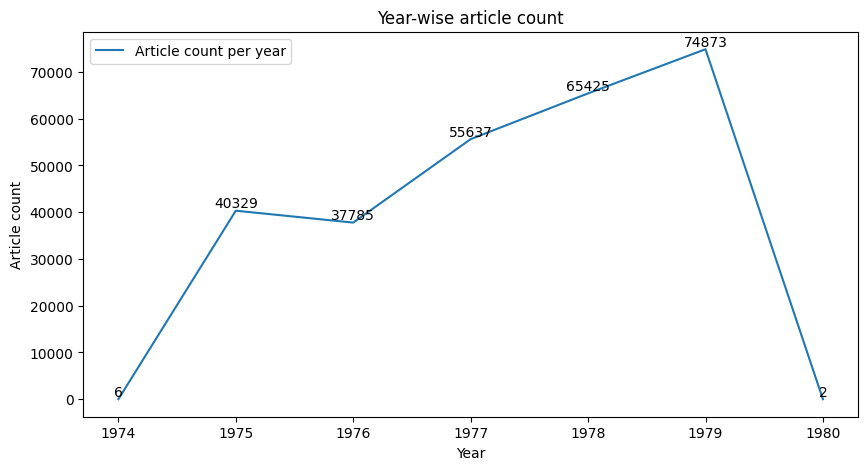

In [46]:
# Read year-wise article counts.
year_counts = pd.read_csv("output/year_counts/year_counts.csv")
year_counts = year_counts[year_counts["Year"] != "Unknown"]

plt.figure(figsize=(10, 5))
plt.plot(year_counts["Year"], year_counts["count"], label="Article count per year")
plt.xlabel("Year")
plt.ylabel("Article count")
plt.title("Year-wise article count")

# Legend with the count per year
for year, count in zip(year_counts["Year"], year_counts["count"]):
    plt.text(year, count, str(count), ha="center", va="bottom")

plt.legend()

plt.show()


### 2. How many articles were published per author? 

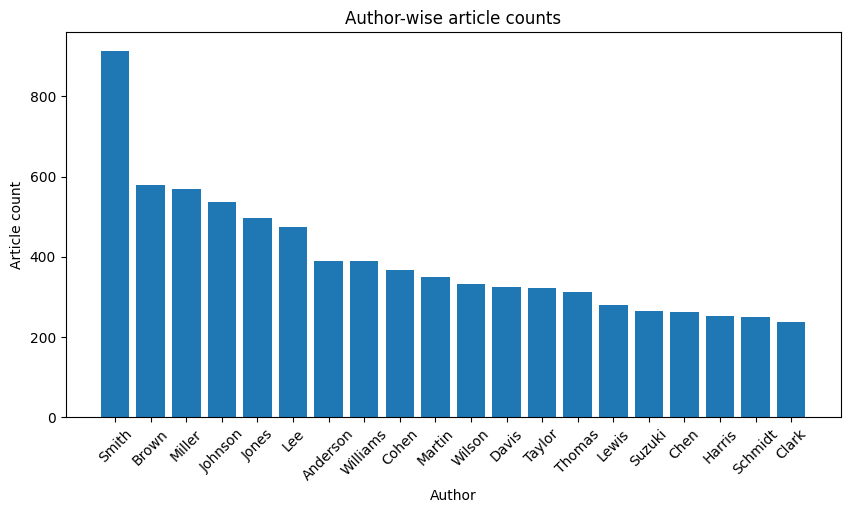

In [25]:

# top 20 authors ans skip unknown authors
author_counts = pd.read_csv("output/author_counts/author_counts.csv")
author_counts = author_counts[~(author_counts['FirstAuthor'] == 'Unknown')]
author_counts = author_counts.sort_values(by="count", ascending=False).head(20)

plt.figure(figsize=(10, 5))
plt.bar(author_counts["FirstAuthor"], author_counts["count"])
plt.title("Author-wise article counts")
plt.xlabel("Author")
plt.ylabel("Article count")
plt.xticks(rotation=45)
plt.show()

### 3. minumum, maximum, and average length of an abstract?

In [28]:
# abstract length
abstract_lengths = pd.read_csv("output/abstract_lengths/abstract_lengths.csv")
# print the min abstract length
print(f"Minimum abstract length: {abstract_lengths['MinAbstractLength'].iloc[0]}")
# print the max abstract length
print(f"Maximum abstract length: {abstract_lengths['MaxAbstractLength'].iloc[0]}")
# print the average abstract length
print(f"Average abstract length: {abstract_lengths['AvgAbstractLength'].iloc[0]}")

Minimum abstract length: 0
Maximum abstract length: 4203
Average abstract length: 406.38746333333336


### 4. How many articles were published per journal per year?

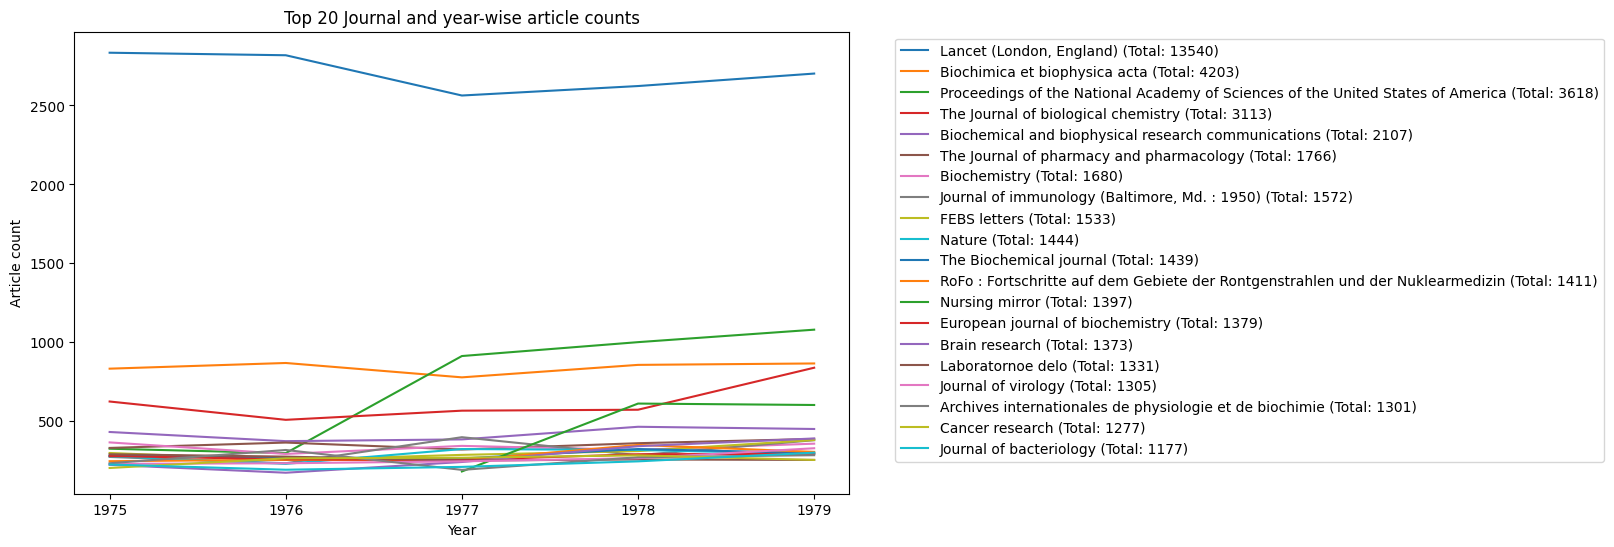

In [45]:
# Read data for journal and year-wise article counts
journal_year_counts = pd.read_csv("output/journal_year_counts/journal_year_counts.csv")
journal_year_counts = journal_year_counts[
    (journal_year_counts["JournalTitle"] != "Unknown") &
    (journal_year_counts["Year"] != "Unknown")
]

# Sort the data by Year and JournalTitle
journal_year_counts = journal_year_counts.sort_values(by=["Year", "JournalTitle"])

# Get the top 20 journals based on the total article count
top_journals = journal_year_counts.groupby("JournalTitle").sum().sort_values(by="count", ascending=False).head(20)

# Plot year-wise article counts for each top journal
plt.figure(figsize=(10, 6))
for journal in top_journals.index:
    journal_df = journal_year_counts[journal_year_counts["JournalTitle"] == journal]
    total_count = top_journals.loc[journal]["count"]
    plt.plot(journal_df["Year"], journal_df["count"], label=f"{journal} (Total: {total_count})")
plt.xlabel("Year")
plt.ylabel("Article count")
plt.title("Top 20 Journal and year-wise article counts")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
